# SWYFT tutorial

This tutorial highlights three aspects of *swyft*.

- The general *swyft* API. It is somewhat verbose right now, but will be stream-lined in the future.
- For simple problems like linear regression *swyft* reproduces known results.
- Solving hard problems, like the marginalization over a high-dimensional nuiscance parameter space with $10^{18}$ modes, becomes (almost) as simple as linear regression.


In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)

## Imports

In [2]:
# Install swyft when on google colab
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [3]:
# Standard imports
import numpy as np
import pylab as plt
from scipy import stats
import torch

# Set randomness
np.random.seed(25)
torch.manual_seed(25)

# Import swyft
import swyft
DEVICE = 'cuda'

### Image model

In [4]:
log10_M_smooth_low, log10_M_smooth_high = 8.0, 9.5
prior = swyft.Prior(
        lambda u: (log10_M_smooth_high - log10_M_smooth_low) * u + log10_M_smooth_low,
        1,
        n=10,
    )

In [59]:
#store = swyft.DirectoryStore(["log10_M_smooth"], path='/nfs/scratch/amcoogan/lensing/log10_M_smooth-20000.zarr')
store = swyft.MemoryStore.load('/nfs/scratch/amcoogan/lensing/log10_M_smooth-20000.zarr')

Loading existing store.


In [227]:
dataset = swyft.Dataset(20000, prior, store)

In [229]:
img_mean = sum([dataset[i][0]['image'] for i in range(100)])/100

0.8929247260093689


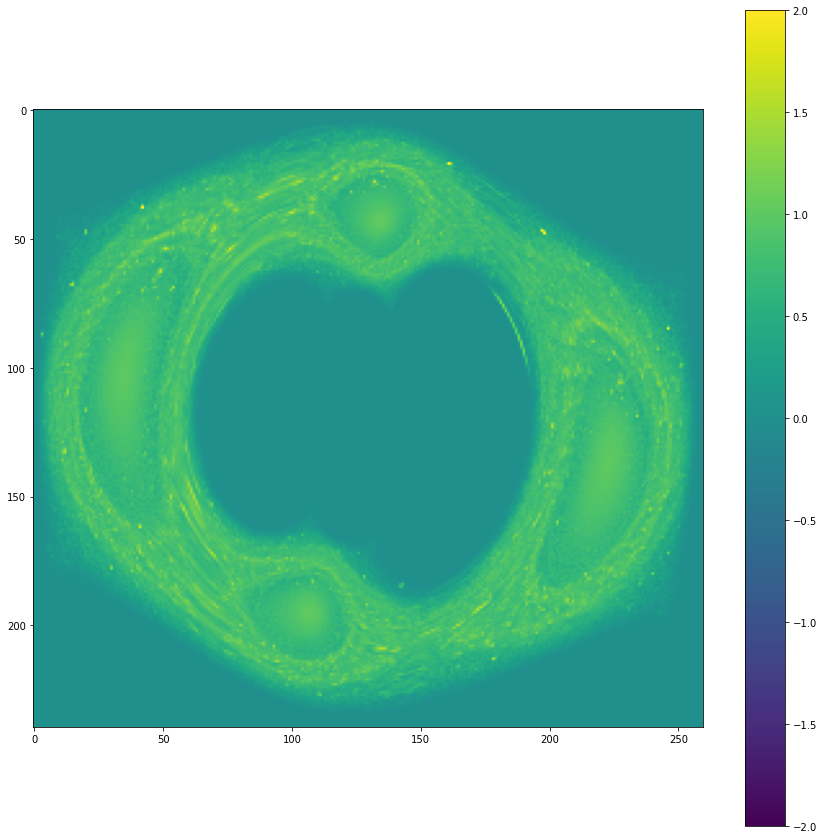

In [366]:
i = 27
img = dataset[i][0]['image']/(img_mean+1)
img = img[80:320, 70:330]
z = dataset[i][1].item()
print(z)
plt.figure(figsize = (15, 15))
plt.imshow(img, vmin = -2, vmax = 2)
plt.colorbar()

### Head network

We write a simple convolutional neural network as head network. The `forward` method has to take as input the data, and output a single vector. The network has to be written such that it can be batched.

In [381]:
m0 = img_mean.to(DEVICE)+1

class Head(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 80
        
        #self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([240,260]), use_average_std = True)
        self.conv1 = torch.nn.Conv2d(1, 10, 3)
        self.conv2 = torch.nn.Conv2d(10, 20, 3)
        self.conv3 = torch.nn.Conv2d(20, 30, 3)
        self.conv4 = torch.nn.Conv2d(30, 40, 3)
        self.pool = torch.nn.MaxPool2d(2)
        self.apool = torch.nn.AvgPool2d(4)
        #self.linear = torch.nn.Linear(40*40, 10)

    def forward(self, obs):
        x=obs['image']/m0
        x = x[:, 80:320, 70:330]
        nbatch = len(x)
        #x = self.onl_f(x)
        x = self.apool(x)
        
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        
        x = x.view(nbatch, -1)
        #print(x.shape)
        #x = self.linear(x)
        
        return x

### Running the analysis

Analysing the image is now simple. We just provide an instance of the `Head` network as argument to `NestedRatios.run` and `NestedRatios.gen_1d_marginals` . That's it.

In [382]:
post = swyft.Posteriors(prior)

In [383]:
marginals = [0]
post.add(marginals, device = DEVICE, head = Head)

In [ ]:
post.train(marginals, dataset, train_args = dict(batch_size = 32, nworkers = 0, max_epochs = 5))

In [ ]:
post.train_diagnostics(((0,),))

### 1-dim posteriors for reference image

And voila. The posteriors estimated by the network agree well with the input parameters.

In [14]:
samples=post.sample(100000, obs0)

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='0'>, <AxesSubplot:xlabel='1'>,
        <AxesSubplot:xlabel='2'>], dtype=object))

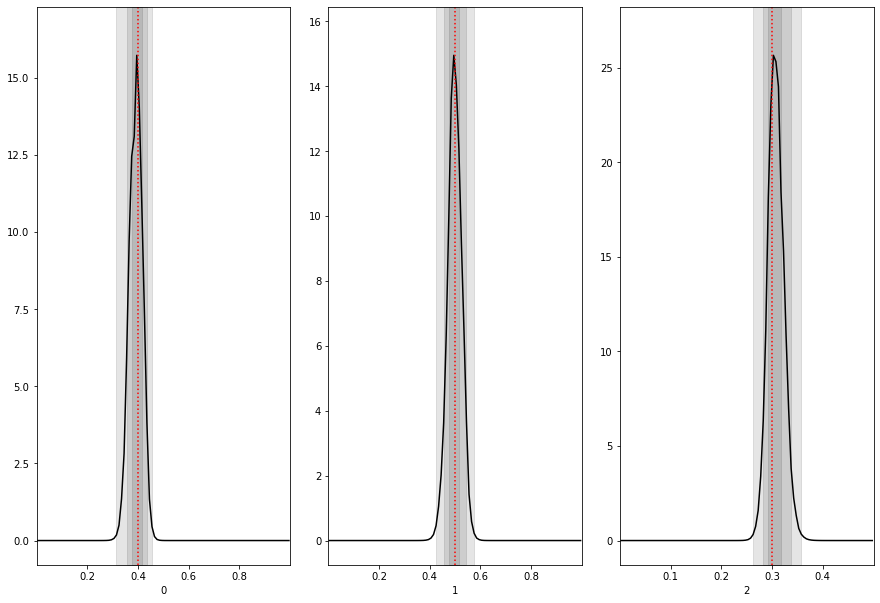

In [15]:
swyft.plot1d(samples, [0, 1, 2], truth = v0)

### Amortised posteriors

Since we only trained the network for one round - on the full model parameter space, we can actually also quickly generate posteriors for other images. This comes at no extra costs, since the network amortised all possible posteriors.

In [18]:
def plot_posterior(i):
    obs, u = dataset[i]
    plt.imshow(obs['x'])
    samples=post.sample(100000, obs)
    v = prior.v(u.reshape(1,-1))[0]
    swyft.plot1d(samples, [0, 1, 2], truth=v)

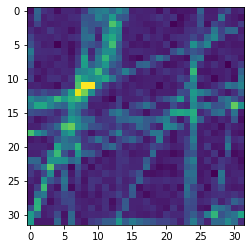

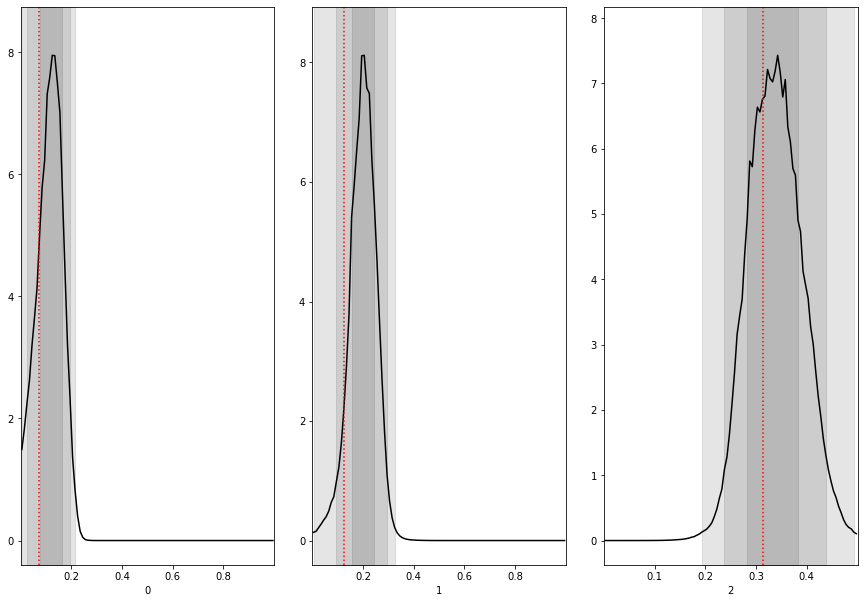

In [19]:
plot_posterior(0)

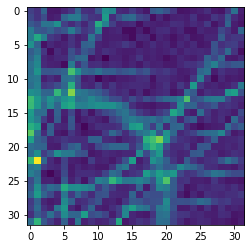

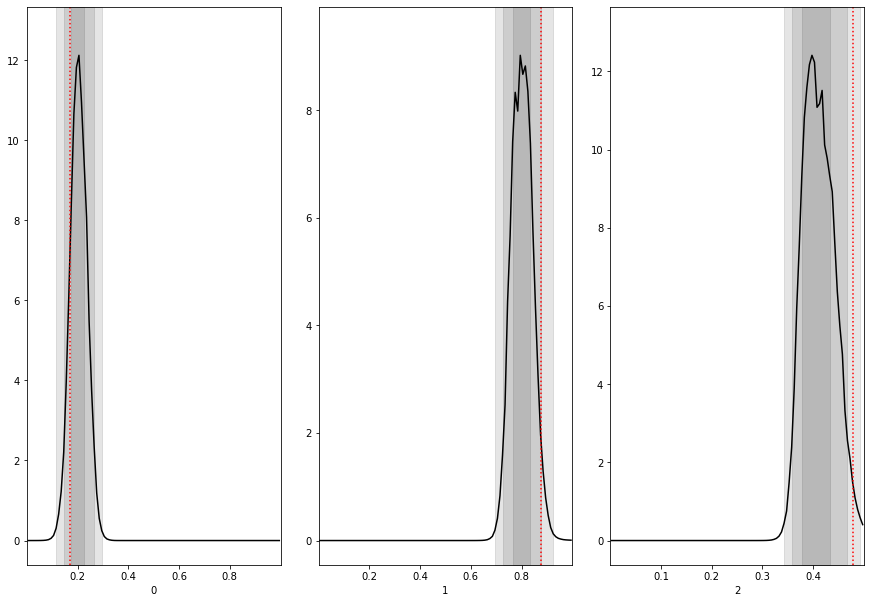

In [20]:
plot_posterior(1)

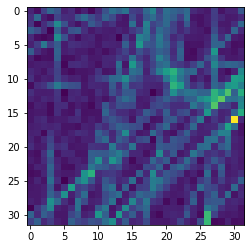

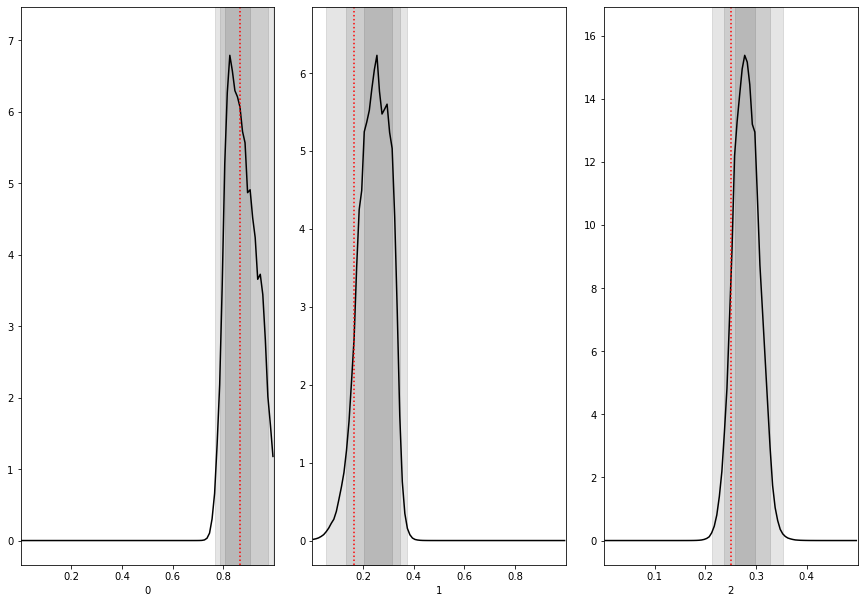

In [21]:
plot_posterior(2)

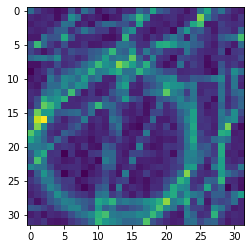

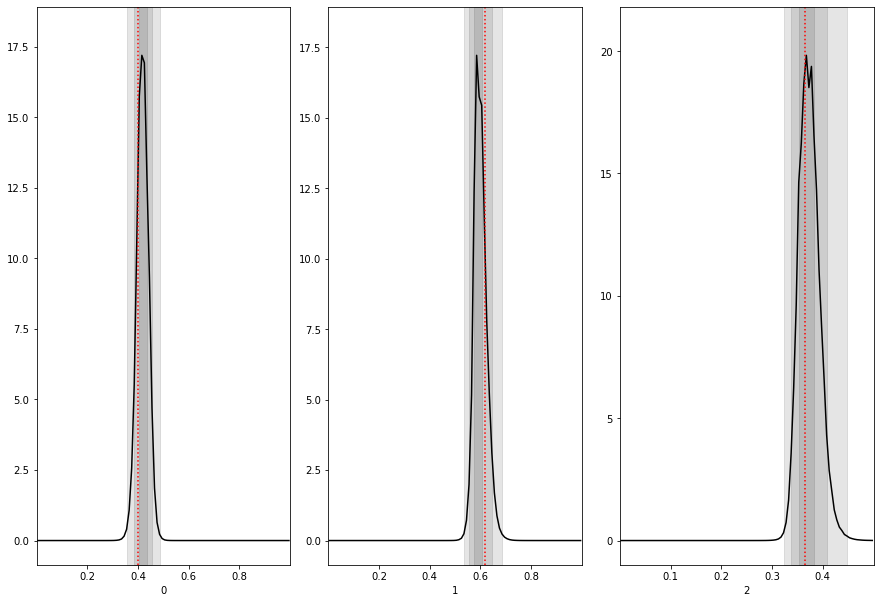

In [22]:
plot_posterior(3)

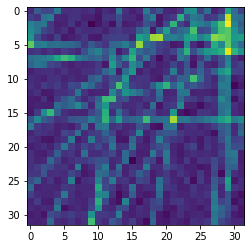

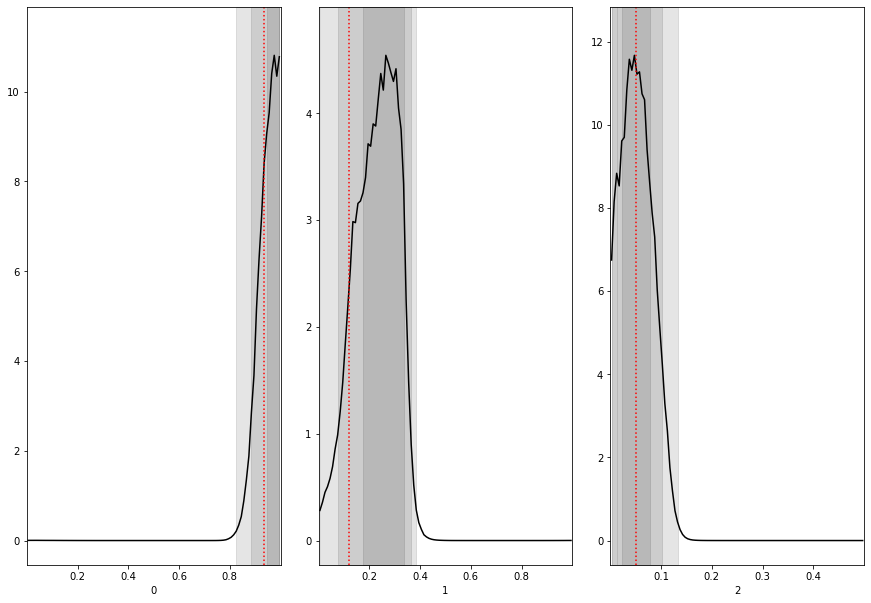

In [23]:
plot_posterior(4)

In [24]:
marginals_2d = [(0, 1), (0, 2), (1, 2)]
post.add(marginals_2d, device = DEVICE, head = Head)
post.train(marginals_2d, dataset)

Training: lr=1e-05, Epoch=17, VL=1.6996


(<Figure size 720x720 with 9 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='1'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='0', ylabel='2'>, <AxesSubplot:xlabel='1'>,
         <AxesSubplot:xlabel='2'>]], dtype=object))

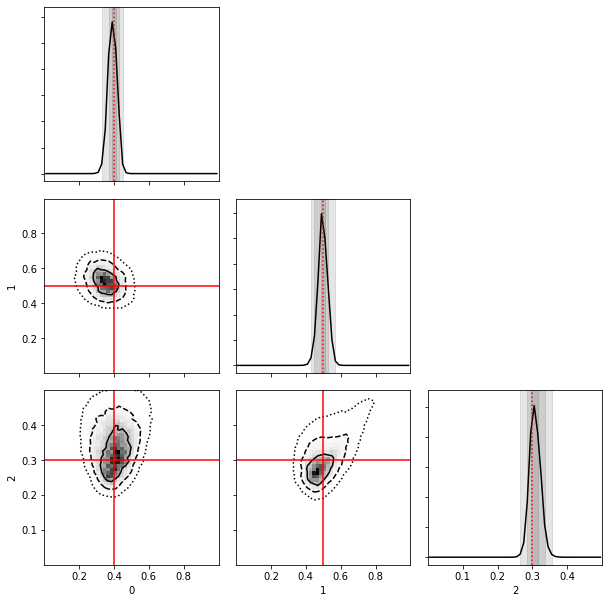

In [25]:
samples = post.sample(100000, obs0)
swyft.corner(samples, [0, 1, 2], truth = v0, bins = 50)

## Some final words - Unleashing the power of marginal posterior estimation

- It is notable that the last results are obtained with just 5000 training images and a very simple head network.  At the same time, obtaining similar results - even for a single image - with a pure likelihood-based approach would be rediciously challenging, since the full joint 43-dim posterior that would have to be explored has ~$10^{18}$ modes (the lines are permutation symmetric, which gives a factor $20!$).
- We note that more training data or a more expressive head network would potentially improve the quality of the results.
- More information about the underlying theory and the code structure can be found on https://swyft.readthedocs.io/en/latest/, as well as the papers that are referenced there.